<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-09-07 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


# Formatting for PyUnfold use
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)
6. [Feature importance](#Feature-importance)

In [2]:
%matplotlib inline
from __future__ import division, print_function
import os
from collections import defaultdict
import numpy as np
from scipy.sparse import block_diag
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import json

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold

import comptools as comp
import comptools.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

Define energy binning for this analysis

In [4]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [5]:
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012')

In [6]:
log_energy_sim_test = df_sim_test['lap_log_energy']
log_reco_energy_sim_test = df_sim_test['lap_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']

In [7]:
feature_list, feature_labels = comp.analysis.get_training_features()

In [8]:
pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

In [9]:
pipeline

Pipeline(steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

In [10]:
pipeline.fit(df_sim_train[feature_list], df_sim_train['target'])

Pipeline(steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

In [11]:
df_data = comp.load_data(config='IC86.2012')

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:138: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_energy'] = np.log10(df['d4r_peak_energy'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:139: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_sigma'] = np.log10(df['d4r_peak_sigma'])


In [12]:
X_data = comp.dataframe_functions.dataframe_to_array(df_data, feature_list + ['lap_log_energy'])
log_energy_data = X_data[:,-1]
X_data = X_data[:,:-1]

In [13]:
# is_finite_mask = np.isfinite(data.X)
# not_finite_mask = np.logical_not(is_finite_mask)
# finite_data_mask = np.logical_not(np.any(not_finite_mask, axis=1))
# data = data[finite_data_mask]

In [14]:
data_predictions = pipeline.predict(X_data)

In [15]:
# Get composition masks
data_labels = np.array([comp.dataframe_functions.label_to_comp(pred) for pred in data_predictions])
data_light_mask = data_labels == 'light'
data_heavy_mask = data_labels == 'heavy'

In [16]:
# Get number of identified comp in each energy bin
df_flux = {}
comp_list = ['light', 'heavy']
for composition in comp_list:
    comp_mask = data_labels == composition
    df_flux['counts_' + composition] = np.histogram(log_energy_data[comp_mask],
                                            bins=energybins.log_energy_bins)[0]
    df_flux['counts_' + composition + '_err'] = np.sqrt(df_flux['counts_' + composition])

df_flux['counts_total'] = np.histogram(log_energy_data, bins=energybins.log_energy_bins)[0]
df_flux['counts_total_err'] = np.sqrt(df_flux['counts_total'])

In [17]:
# Get number of identified comp in each energy bin
unfolding_df = pd.DataFrame(df_flux)
comp_list = ['light', 'heavy']
for composition in comp_list:
    comp_mask = data_labels == composition
    unfolding_df['counts_' + composition] = np.histogram(log_energy_data[comp_mask],
                                            bins=energybins.log_energy_bins)[0]
    unfolding_df['counts_' + composition + '_err'] = np.sqrt(df_flux['counts_' + composition])

unfolding_df['counts_total'] = np.histogram(log_energy_data, bins=energybins.log_energy_bins)[0]
unfolding_df['counts_total_err'] = np.sqrt(unfolding_df['counts_total'])

In [18]:
unfolding_df.index.rename('log_energy_bin_idx', inplace=True)

In [19]:
unfolding_df

,counts_heavy,counts_heavy_err,counts_light,counts_light_err,counts_total,counts_total_err
log_energy_bin_idx,,,,,,
0,233037,482.739060,360613,600.510616,593650,770.486859
1,145728,381.743369,256442,506.401027,402170,634.168747
2,99038,314.703035,164393,405.454066,263431,513.255297
3,66484,257.844915,102273,319.801501,168757,410.800438
4,40849,202.111355,64793,254.544692,105642,325.026153
5,29647,172.183042,35326,187.952122,64973,254.898019
6,19869,140.957440,20067,141.658039,39936,199.839936
7,12063,109.831689,12687,112.636584,24750,157.321327
8,7940,89.106678,7543,86.850446,15483,124.430704


## Spectrum
[ [back to top](#top) ]

### Number of events observed

In [20]:
# num_particles, num_particles_err = comp.analysis.get_num_particles(sim_train, data, pipeline, comp_list)

In [21]:
# unfolding_df['counts_light'] = num_particles['light']
# unfolding_df['counts_heavy'] = num_particles['heavy']
# unfolding_df['counts_err_light'] = num_particles_err['light']
# unfolding_df['counts_err_heavy'] = num_particles_err['heavy']

### Block diagonal response matrix and error

In [22]:
# pipeline.fit(sim_train.X, sim_train.y)
test_predictions = pipeline.predict(df_sim_test[feature_list])
true_comp = df_sim_test['target'].apply(comp.dataframe_functions.label_to_comp)
pred_comp = pd.Series([comp.dataframe_functions.label_to_comp(i) for i in test_predictions])

In [23]:
print(test_predictions)
print(true_comp)
print(pred_comp)

[0 0 0 ..., 0 1 0]
0        heavy
1        light
2        heavy
3        heavy
4        heavy
5        light
6        heavy
7        light
8        light
9        light
10       heavy
11       light
12       light
13       light
14       light
15       light
16       light
17       light
18       heavy
19       light
20       light
21       light
22       light
23       light
24       heavy
25       light
26       heavy
27       light
28       light
29       light
         ...  
21508    heavy
21509    light
21510    heavy
21511    light
21512    light
21513    heavy
21514    light
21515    heavy
21516    light
21517    heavy
21518    light
21519    light
21520    light
21521    heavy
21522    heavy
21523    light
21524    heavy
21525    heavy
21526    heavy
21527    light
21528    light
21529    light
21530    heavy
21531    heavy
21532    heavy
21533    light
21534    heavy
21535    heavy
21536    heavy
21537    light
Name: target, Length: 21538, dtype: object
0        light
1       

In [24]:
response_list = []
response_err_list = []
sim_bin_idxs = np.digitize(log_energy_sim_test, energybins.log_energy_bins) - 1
energy_bin_idx = np.unique(sim_bin_idxs)
# energy_bin_idx = energy_bin_idx[1:]
print(energy_bin_idx)
# print(energybins.energy_midpoints.shape)
for bin_idx in energy_bin_idx:
    if (bin_idx == -1) or (bin_idx == energybins.energy_midpoints.shape[0]):
        continue
    sim_bin_mask = sim_bin_idxs == bin_idx
    response_mat = confusion_matrix(true_comp[sim_bin_mask], pred_comp[sim_bin_mask],
                                    labels=comp_list)
    # Transpose response matrix to get MC comp on x-axis and reco comp on y-axis
    response_mat = response_mat.T
    # Get response matrix statistical error
    response_mat_err = np.sqrt(response_mat)
    response_err_list.append(response_mat_err)
    response_list.append(response_mat)
block_response = block_diag(response_list).toarray()
# block_response = np.flipud(block_response)

# Normalize along MC comp axis to go from counts to probabilities
block_response = block_response / block_response.sum(axis=0)
print('block_response = \n{}'.format(block_response))
block_response_err = block_diag(response_err_list).toarray()
# block_response_err = np.flipud(block_response_err)
block_response_err = block_response_err / block_response_err.sum(axis=0)
print('block_response_err = \n{}'.format(block_response_err))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
block_response = 
[[ 0.70350404  0.20845481  0.         ...,  0.          0.          0.        ]
 [ 0.29649596  0.79154519  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.75585697 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.8125      0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.68095238
   0.10526316]
 [ 0.          0.          0.         ...,  0.          0.31904762
   0.89473684]]
block_response_err = 
[[ 0.60635593  0.33913925  0.         ...,  0.          0.          0.        ]
 [ 0.39364407  0.66086075  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.63761996 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.6755002   0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.59365023
   0.25539679]
 [ 0. 

In [25]:
res_mat_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'block_response.txt')
res_mat_err_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'block_response_err.txt')

comp.check_output_dir(res_mat_outfile)
comp.check_output_dir(res_mat_err_outfile)

np.savetxt(res_mat_outfile, block_response)
np.savetxt(res_mat_err_outfile, block_response_err)

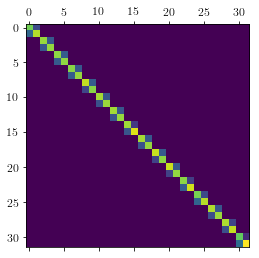

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [26]:
plt.matshow(block_response)

In [27]:
block_response

array([[ 0.70350404,  0.20845481,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29649596,  0.79154519,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.75585697, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.8125    ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.68095238,  0.10526316],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.31904762,  0.89473684]])

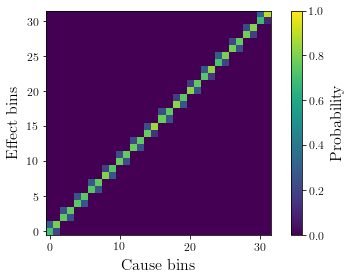

In [28]:
plt.imshow(block_response, origin='lower', vmin=0, vmax=1)
# fig, ax = plt.subplots()
# sns.heatmap(block_response, square=True, vmin=0, vmax=1, cmap='viridis', ax=ax,
#             cbar_kws={'label': 'Proability'})
plt.xlabel('Cause bins')
plt.ylabel('Effect bins')
plt.colorbar(label='Probability')
res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix-block.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)

In [30]:
true_ebin_idxs = np.digitize(log_true_energy_sim_test, energybins.log_energy_bins) - 1
reco_ebin_idxs = np.digitize(log_reco_energy_sim_test, energybins.log_energy_bins) - 1
energy_bin_idx = np.unique(true_ebin_idxs)
print(energy_bin_idx)

hstack_list = []
for true_ebin_idx in energy_bin_idx:
    if (true_ebin_idx == -1) or (true_ebin_idx == energybins.energy_midpoints.shape[0]):
        continue
    true_ebin_mask = true_ebin_idxs == true_ebin_idx
    
    vstack_list = []
    for reco_ebin_idx in energy_bin_idx:
        if (reco_ebin_idx == -1) or (reco_ebin_idx == energybins.energy_midpoints.shape[0]):
            continue
        reco_ebin_mask = reco_ebin_idxs == reco_ebin_idx
        
        combined_mask = true_ebin_mask & reco_ebin_mask
        if combined_mask.sum() == 0:
            response_mat = np.zeros((2, 2), dtype=int)
        else:
            response_mat = confusion_matrix(true_comp[true_ebin_mask & reco_ebin_mask],
                                            pred_comp[true_ebin_mask & reco_ebin_mask],
                                            labels=comp_list)
        # Transpose response matrix to get MC comp on x-axis and reco comp on y-axis
        response_mat = response_mat.T
        vstack_list.append(response_mat)
    hstack_list.append(np.vstack(vstack_list))
res = np.hstack(hstack_list)
res_err = np.sqrt(res)
# Normalize column-wise
res = res / res.sum(axis=0)
res_err = res_err / res_err.sum(axis=0)

# # Flip to get formatting correct for PyUnfold
# res = np.flipud(res)
# res_err = np.flipud(res_err)




#         # Get response matrix statistical error
#         response_mat_err = np.sqrt(response_mat)/response_mat.sum(axis=0, keepdims=True)
#         response_err_list.append(response_mat_err)
#         # Normalize along MC comp axis to go from counts to probabilities
#         response_mat = response_mat.astype(float)/response_mat.sum(axis=0, keepdims=True)
#         response_list.append(response_mat)
# block_response = block_diag(response_list).toarray()
# block_response = np.flipud(block_response)
# print('block_response = \n{}'.format(block_response))
# block_response_err = block_diag(response_err_list).toarray()
# block_response_err = np.flipud(block_response_err)
# print('block_response_err = \n{}'.format(block_response_err))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


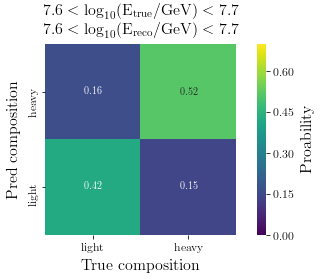

In [41]:
fig, ax = plt.subplots()
# h = np.flipud(block_response)
sns.heatmap(res[24:26, 24:26], annot=True, ax=ax, square=True,
           xticklabels=['light', 'heavy'], yticklabels=['light', 'heavy'],
           cbar_kws={'label': 'Proability'}, vmin=0, vmax=0.7, cmap='viridis')
ax.invert_yaxis()
plt.xlabel('True composition')
plt.ylabel('Pred composition')
plt.title('$\mathrm{7.6 < \log_{10}(E_{true}/GeV) < 7.7}$' + '\n$\mathrm{7.6 < \log_{10}(E_{reco}/GeV) < 7.7}$')
res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix-single-energy-bin.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

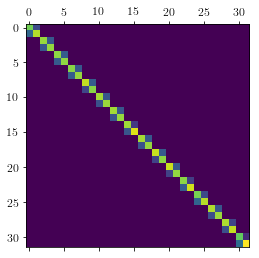

In [31]:
plt.matshow(block_response)

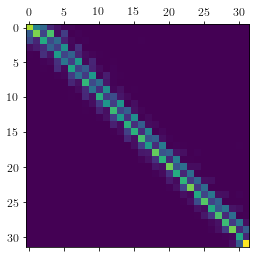

In [32]:
plt.matshow(res)

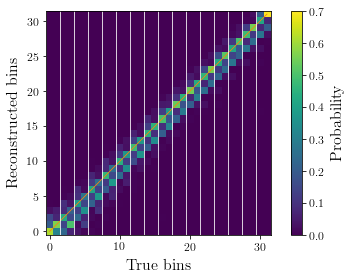

In [42]:
plt.imshow(res, origin='lower')
plt.plot((0, res.shape[0]-1), (0, res.shape[1]-1), marker='None', ls='-', color='C1')

for i in np.arange(0, res.shape[0], 2):
    plt.axvline(i-0.5, marker='None', ls='-', color='white')
# for i in np.arange(0, res.shape[0], 2):
#     plt.axvline(i+0.5, marker='None', ls=':', color='gray')
# for i in np.arange(0, res.shape[0], 2):
#     plt.axhline(i-0.5, marker='None', ls='-', color='white')
# for i in np.arange(0, res.shape[0], 2):
#     plt.axhline(i+0.5, marker='None', ls=':', color='gray')
    
plt.xlabel('True bins')
plt.ylabel('Reconstructed bins')

# plt.xticks(np.arange(0.5, res.shape[0], 2),
#            ['{}'.format(i+1) for i in range(res.shape[0])], 
#            rotation='vertical')
# plt.yticks(np.arange(0.5, res.shape[0], 2),
#            ['{}'.format(i+1) for i in range(res.shape[0])])
plt.colorbar(label='Probability')

res_mat_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'response-matrix.png')
comp.check_output_dir(res_mat_outfile)
plt.savefig(res_mat_outfile)
plt.show()

In [57]:
block_response.sum(axis=1)

array([ 0.91195885,  1.08804115,  1.00168398,  0.99831602,  0.99819434,
        1.00180566,  0.98017328,  1.01982672,  1.07604786,  0.92395214,
        1.0125882 ,  0.9874118 ,  1.01459797,  0.98540203,  0.91396573,
        1.08603427,  1.02115872,  0.97884128,  1.07754011,  0.92245989,
        1.07141559,  0.92858441,  0.90512225,  1.09487775,  0.91315357,
        1.08684643,  1.02546393,  0.97453607,  0.97044574,  1.02955426,
        0.78621554,  1.21378446])

In [58]:
np.flipud(res).sum(axis=1)

array([ 0.92517903,  0.50609985,  0.99542739,  0.94517686,  1.00114942,
        1.00375226,  1.06986994,  0.95168168,  1.10005996,  0.93127346,
        0.88722974,  1.10642353,  0.96434094,  1.08990472,  0.93139657,
        1.02771001,  1.01881054,  0.87708462,  1.01135034,  0.9723711 ,
        1.03640997,  0.9137261 ,  0.84797941,  1.02614367,  0.96739603,
        0.9471558 ,  0.98157149,  0.99562593,  0.96972846,  1.14455249,
        1.571114  ,  1.28230471])

In [59]:
res_mat_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'response.txt')
res_mat_err_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'response_err.txt')

comp.check_output_dir(res_mat_outfile)
comp.check_output_dir(res_mat_err_outfile)

np.savetxt(res_mat_outfile, res)
np.savetxt(res_mat_err_outfile, res_err)

### Priors array

In [60]:
from icecube.weighting.weighting import from_simprod
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5

In [61]:
df_sim = comp.load_sim(config='IC86.2012', test_size=0)
df_sim.head()

,FractionContainment_Laputop_IceTop,FractionContainment_Laputop_InIce,FractionContainment_MCPrimary_IceTop,FractionContainment_MCPrimary_InIce,IceTopMaxSignal,IceTopMaxSignalInEdge,IceTopMaxSignalString,IceTopNeighbourMaxSignal,InIce_charge_1_60,MC_azimuth,...,log_s80,log_s125,log_s180,log_s250,log_s500,log_dEdX,log_d4r_peak_energy,log_d4r_peak_sigma,target,is_thinned
0,0.672916,0.596048,0.675481,0.649017,28.609421,0,29,12.178488,180.050000,5.673565,...,0.515847,-0.023232,-0.480570,-0.905580,-1.842779,0.733548,1.251190,0.905364,0,False
1,0.537961,0.760892,0.543832,0.771945,101.481819,0,38,68.172859,244.275001,5.673565,...,0.560367,-0.013838,-0.499876,-0.950742,-1.942496,0.758869,1.096959,0.790880,0,False
2,0.676321,0.597996,0.674722,0.655864,20.867756,0,20,10.946673,165.950000,5.673565,...,0.502415,-0.000583,-0.428441,-0.826892,-1.708051,0.363861,1.511975,1.486399,0,False
3,0.255498,0.933506,0.248732,0.951277,37.628693,0,80,21.158876,27.025000,5.673565,...,0.507438,-0.057127,-0.535289,-0.979059,-1.955840,0.663036,0.807850,0.452333,0,False
4,0.389801,0.887318,0.378421,0.896916,19.827286,0,27,6.790532,59.850000,5.673565,...,0.533604,-0.027082,-0.502074,-0.942989,-1.913746,0.510647,0.917567,0.767052,0,False


In [62]:
flux = GaisserH3a()
model_flux = {}
for ptype in [2212, 1000020040, 1000070140, 1000130270, 1000260560]:
    model_flux[ptype] = flux(energybins.energy_midpoints, ptype)
model_flux_df = pd.DataFrame.from_records(model_flux)
model_flux_df.index = energybins.energy_midpoints
model_flux_df

,2212,1000020040,1000070140,1000130270,1000260560
2.818383e+06,3.365669e-14,6.392754e-14,2.639297e-14,1.291653e-14,2.724088e-14
3.548134e+06,1.593250e-14,3.266399e-14,1.423278e-14,7.084518e-15,1.492133e-14
4.466836e+06,7.341097e-15,1.637122e-14,7.639624e-15,3.881777e-15,8.165225e-15
5.623413e+06,3.290494e-15,8.016199e-15,4.077046e-15,2.123919e-15,4.462350e-15
7.079458e+06,1.439990e-15,3.818003e-15,2.160371e-15,1.159933e-15,2.434567e-15
8.912509e+06,6.217267e-16,1.761449e-15,1.134859e-15,6.319534e-16,1.325349e-15
1.122018e+07,2.697351e-16,7.849163e-16,5.899540e-16,3.432667e-16,7.194980e-16
1.412538e+07,1.201025e-16,3.380352e-16,3.029216e-16,1.857741e-16,3.892281e-16
1.778279e+07,5.550538e-17,1.417695e-16,1.533412e-16,1.001021e-16,2.096403e-16
2.238721e+07,2.639513e-17,5.896673e-17,7.640552e-17,5.366749e-17,1.123032e-16


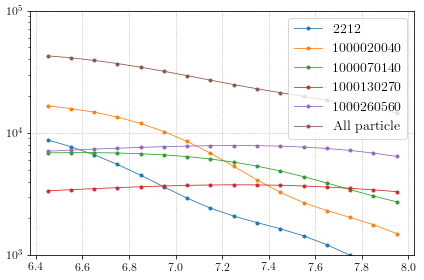

In [63]:
fig, ax = plt.subplots()
for key in model_flux_df.columns:
    ax.plot(np.log10(model_flux_df.index), model_flux_df.index**2.7*model_flux_df[key], label=key)
ax.plot(np.log10(model_flux_df.index), model_flux_df.index**2.7*model_flux_df.sum(axis=1), label='All particle')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim(1e3, 1e5)
ax.grid()
ax.legend()
plt.show()

In [64]:
model_flux_df.sum(axis=1)

2.818383e+06    1.641346e-13
3.548134e+06    8.483512e-14
4.466836e+06    4.339894e-14
5.623413e+06    2.197001e-14
7.079458e+06    1.101287e-14
8.912509e+06    5.475336e-15
1.122018e+07    2.707370e-15
1.412538e+07    1.336061e-15
1.778279e+07    6.603585e-16
2.238721e+07    3.277380e-16
2.818383e+07    1.634461e-16
3.548134e+07    8.178036e-17
4.466836e+07    4.092131e-17
5.623413e+07    2.040978e-17
7.079458e+07    1.012960e-17
8.912509e+07    5.005529e-18
dtype: float64

In [65]:
simlist = np.unique(df_sim['sim'])
for i, sim in enumerate(simlist):
    gcd_file, sim_files = comp.simfunctions.get_level3_sim_files(sim)
    num_files = len(sim_files)
    if i == 0:
        generator = num_files*from_simprod(int(sim))
    else:
        generator += num_files*from_simprod(int(sim))

In [66]:
priors_list = ['h3a', 'h4a', 'antih3a', 'Hoerandel5', 'antiHoerandel5']
# priors_list = ['h3a', 'h4a', 'antih3a', 'Hoerandel5', 'antiHoerandel5', 'uniform', 'alllight', 'allheavy']
model_ptypes = {}
model_ptypes['h3a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['h4a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['Hoerandel5'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}

In [67]:
priors = defaultdict(list)
for flux, name in zip([GaisserH3a(), GaisserH3a(), GaisserH4a(), Hoerandel5(), Hoerandel5()],
                      ['h3a', 'antih3a', 'h4a', 'Hoerandel5', 'antiHoerandel5']):
    priors_raw = defaultdict(list)
    for energy_mid in energybins.energy_midpoints:
        energy = [energy_mid]*5
        ptype = [2212, 1000020040, 1000070140, 1000130270, 1000260560]
        weights = flux(energy, ptype)
#         light_prior = weights[:2].sum()/weights.sum()
#         heavy_prior = weights[2:].sum()/weights.sum()
        light_prior = weights[:2].sum()
        heavy_prior = weights[2:].sum()
        if 'anti' in name:
            priors_raw['light'].append(heavy_prior)
            priors_raw['heavy'].append(light_prior)
        else:
            priors_raw['light'].append(light_prior)
            priors_raw['heavy'].append(heavy_prior)
        priors[name].extend([light_prior, heavy_prior])
    unfolding_df['{}_flux_light'.format(name)] = priors_raw['light']
    unfolding_df['{}_flux_heavy'.format(name)] = priors_raw['heavy']
    
# unfolding_df['uniform_flux_light'] = [0.5]*len(priors_raw['light'])
# unfolding_df['uniform_flux_heavy'] = [0.5]*len(priors_raw['heavy'])

# unfolding_df['alllight_flux_light'] = [0.9]*len(priors_raw['light'])
# unfolding_df['alllight_flux_heavy'] = [0.1]*len(priors_raw['heavy'])

# unfolding_df['allheavy_flux_light'] = [0.1]*len(priors_raw['light'])
# unfolding_df['allheavy_flux_heavy'] = [0.9]*len(priors_raw['heavy'])

In [68]:
unfolding_df

,counts_heavy,counts_heavy_err,counts_light,counts_light_err,counts_total,counts_total_err,h3a_flux_light,h3a_flux_heavy,antih3a_flux_light,antih3a_flux_heavy,h4a_flux_light,h4a_flux_heavy,Hoerandel5_flux_light,Hoerandel5_flux_heavy,antiHoerandel5_flux_light,antiHoerandel5_flux_heavy
log_energy_bin_idx,,,,,,,,,,,,,,,,
0,233037,482.739060,360613,600.510616,593650,770.486859,9.758423e-14,6.655038e-14,6.655038e-14,9.758423e-14,9.985590e-14,6.541805e-14,6.629980e-14,6.488824e-14,6.488824e-14,6.629980e-14
1,145728,381.743369,256442,506.401027,402170,634.168747,4.859649e-14,3.623863e-14,3.623863e-14,4.859649e-14,4.981589e-14,3.558706e-14,3.247099e-14,3.528813e-14,3.528813e-14,3.247099e-14
2,99038,314.703035,164393,405.454066,263431,513.255297,2.371232e-14,1.968663e-14,1.968663e-14,2.371232e-14,2.436579e-14,1.931170e-14,1.541614e-14,1.916844e-14,1.916844e-14,1.541614e-14
3,66484,257.844915,102273,319.801501,168757,410.800438,1.130669e-14,1.066331e-14,1.066331e-14,1.130669e-14,1.165624e-14,1.044758e-14,7.062637e-15,1.039346e-14,1.039346e-14,7.062637e-15
4,40849,202.111355,64793,254.544692,105642,325.026153,5.257994e-15,5.754872e-15,5.754872e-15,5.257994e-15,5.444601e-15,5.630737e-15,3.109625e-15,5.620064e-15,5.620064e-15,3.109625e-15
5,29647,172.183042,35326,187.952122,64973,254.898019,2.383175e-15,3.092161e-15,3.092161e-15,2.383175e-15,2.482578e-15,3.020735e-15,1.311693e-15,3.026594e-15,3.026594e-15,1.311693e-15
6,19869,140.957440,20067,141.658039,39936,199.839936,1.054651e-15,1.652719e-15,1.652719e-15,1.054651e-15,1.107476e-15,1.611621e-15,5.294563e-16,1.620381e-15,1.620381e-15,5.294563e-16
7,12063,109.831689,12687,112.636584,24750,157.321327,4.581377e-16,8.779237e-16,8.779237e-16,4.581377e-16,4.861355e-16,8.542774e-16,2.048821e-16,8.604621e-16,8.604621e-16,2.048821e-16
8,7940,89.106678,7543,86.850446,15483,124.430704,1.972749e-16,4.630835e-16,4.630835e-16,1.972749e-16,2.120716e-16,4.494787e-16,7.637870e-17,4.519852e-16,4.519852e-16,7.637870e-17


In [69]:
unfolding_df_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding', 'unfolding-dataframe.csv')
comp.check_output_dir(unfolding_df_outfile)
unfolding_df.to_csv(unfolding_df_outfile)

## Formatting for PyUnfold use

In [70]:
formatted_df = pd.DataFrame()

In [71]:
counts_formatted = []
priors_formatted = defaultdict(list)
for index, row in unfolding_df.iterrows():
    counts_formatted.extend([row['counts_light'], row['counts_heavy']])
    for priors_name in priors_list:
        priors_formatted[priors_name].extend([row[priors_name+'_flux_light'], row[priors_name+'_flux_heavy']])
        
formatted_df['counts'] = counts_formatted
formatted_df['counts_err'] = np.sqrt(counts_formatted)


for key, value in priors_formatted.iteritems():
    formatted_df[key+'_flux'] = value
    formatted_df[key+'_priors'] = formatted_df[key+'_flux'] / formatted_df[key+'_flux'].sum()

formatted_df.index.rename('log_energy_bin_idx', inplace=True)

In [72]:
formatted_df.head()

,counts,counts_err,Hoerandel5_flux,Hoerandel5_priors,h3a_flux,h3a_priors,antiHoerandel5_flux,antiHoerandel5_priors,h4a_flux,h4a_priors,antih3a_flux,antih3a_priors
log_energy_bin_idx,,,,,,,,,,,,
0,360613.0,600.510616,6.629980e-14,0.247104,9.758423e-14,0.290274,6.488824e-14,0.241843,9.985590e-14,0.295078,6.655038e-14,0.197960
1,233037.0,482.739060,6.488824e-14,0.241843,6.655038e-14,0.197960,6.629980e-14,0.247104,6.541805e-14,0.193313,9.758423e-14,0.290274
2,256442.0,506.401027,3.247099e-14,0.121022,4.859649e-14,0.144555,3.528813e-14,0.131521,4.981589e-14,0.147208,3.623863e-14,0.107795
3,145728.0,381.743369,3.528813e-14,0.131521,3.623863e-14,0.107795,3.247099e-14,0.121022,3.558706e-14,0.105161,4.859649e-14,0.144555
4,164393.0,405.454066,1.541614e-14,0.057457,2.371232e-14,0.070535,1.916844e-14,0.071442,2.436579e-14,0.072002,1.968663e-14,0.058560


Save formatted DataFrame to disk

In [73]:
formatted_df_outfile = os.path.join(comp.paths.comp_data_dir, 'unfolding',
                                    'unfolding-dataframe-PyUnfold-formatted.csv')
comp.check_output_dir(formatted_df_outfile)
formatted_df.to_csv(formatted_df_outfile)

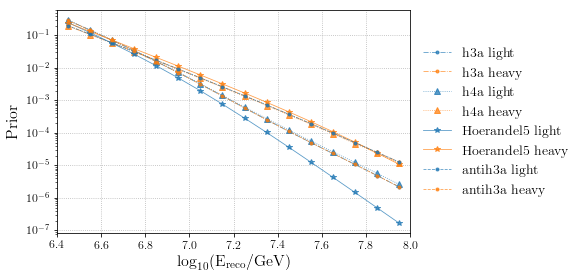

In [77]:
model_to_ls = {'h3a': '-.', 'h4a': ':', 'Hoerandel5': '-', 'antih3a': '--'}
model_to_marker = {'h3a': '.', 'h4a': '^', 'Hoerandel5': '*', 'antih3a': '.'}

fig, ax = plt.subplots()
for model in ['h3a', 'h4a', 'Hoerandel5', 'antih3a']:
    key = '{}_priors'.format(model)
    light_priors = formatted_df[key][::2]
    heavy_priors = formatted_df[key][1::2]
    ax.plot(energybins.log_energy_midpoints, light_priors,
            color=color_dict['light'], ls=model_to_ls[model], marker=model_to_marker[model],
            label='{} light'.format(model), alpha=0.75)
    ax.plot(energybins.log_energy_midpoints, heavy_priors,
            color=color_dict['heavy'], ls=model_to_ls[model], marker=model_to_marker[model],
            label='{} heavy'.format(model), alpha=0.75)

ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('Prior')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
# ax.set_ylim([0, 1])
ax.set_yscale("log", nonposy='clip')
ax.grid()
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                 frameon=False, fancybox=False, numpoints=1)
priors_outfile = os.path.join(comp.paths.figures_dir, 'unfolding/iter-bayesian', 'priors.png')
comp.check_output_dir(priors_outfile)
plt.savefig(priors_outfile)
plt.show()

In [130]:
woo = pd.read_csv(formatted_df_outfile, index_col='log_energy_bin_idx')

In [131]:
woo

,counts,counts_err,Hoerandel5_flux,Hoerandel5_priors,h3a_flux,h3a_priors,antiHoerandel5_flux,antiHoerandel5_priors,h4a_flux,h4a_priors,antih3a_flux,antih3a_priors
log_energy_bin_idx,,,,,,,,,,,,
0,360613.0,600.510616,6.629980e-14,2.471037e-01,9.758423e-14,0.290274,6.488824e-14,2.418428e-01,9.985590e-14,0.295078,6.655038e-14,0.197960
1,233037.0,482.739060,6.488824e-14,2.418428e-01,6.655038e-14,0.197960,6.629980e-14,2.471037e-01,6.541805e-14,0.193313,9.758423e-14,0.290274
2,256442.0,506.401027,3.247099e-14,1.210215e-01,4.859649e-14,0.144555,3.528813e-14,1.315212e-01,4.981589e-14,0.147208,3.623863e-14,0.107795
3,145728.0,381.743369,3.528813e-14,1.315212e-01,3.623863e-14,0.107795,3.247099e-14,1.210215e-01,3.558706e-14,0.105161,4.859649e-14,0.144555
4,164393.0,405.454066,1.541614e-14,5.745698e-02,2.371232e-14,0.070535,1.916844e-14,7.144202e-02,2.436579e-14,0.072002,1.968663e-14,0.058560
5,99038.0,314.703035,1.916844e-14,7.144202e-02,1.968663e-14,0.058560,1.541614e-14,5.745698e-02,1.931170e-14,0.057067,2.371232e-14,0.070535
6,102273.0,319.801501,7.062637e-15,2.632291e-02,1.130669e-14,0.033633,1.039346e-14,3.873710e-02,1.165624e-14,0.034445,1.066331e-14,0.031719
7,66484.0,257.844915,1.039346e-14,3.873710e-02,1.066331e-14,0.031719,7.062637e-15,2.632291e-02,1.044758e-14,0.030873,1.130669e-14,0.033633
8,64793.0,254.544692,3.109625e-15,1.158978e-02,5.257994e-15,0.015640,5.620064e-15,2.094635e-02,5.444601e-15,0.016089,5.754872e-15,0.017118


In [59]:
# with open('pyunfold_dict.json', 'w') as outfile:
#     data = {'counts': counts_observed,
#             'block_response': block_response.tolist(),
#             'block_response_err': block_response_err.tolist()}
#     for model in ['h3a', 'h4a', 'Hoerandel5']:
#         data['priors_{}'.format(model)] = priors[model]
#     json.dump(data, outfile)

NameError: name 'counts_observed' is not defined

In [116]:
df = pd.read_csv(formatted_df_outfile, index_col='log_energy_bin_idx')

In [117]:
df

,counts,allheavy_priors,h3a_priors,h4a_priors,alllight_priors,Hoerandel5_priors,uniform_priors,antih3a_priors,antiHoerandel5_priors
log_energy_bin_idx,,,,,,,,,
0,360613.0,0.1,0.594538,0.604184,0.9,0.505380,0.5,0.405462,0.494620
1,233037.0,0.9,0.405462,0.395816,0.1,0.494620,0.5,0.594538,0.505380
2,256442.0,0.1,0.572835,0.583304,0.9,0.479212,0.5,0.427165,0.520788
3,145728.0,0.9,0.427165,0.416696,0.1,0.520788,0.5,0.572835,0.479212
4,164393.0,0.1,0.546380,0.557857,0.9,0.445752,0.5,0.453620,0.554248
5,99038.0,0.9,0.453620,0.442143,0.1,0.554248,0.5,0.546380,0.445752
6,102273.0,0.1,0.514642,0.527341,0.9,0.404594,0.5,0.485358,0.595406
7,66484.0,0.9,0.485358,0.472659,0.1,0.595406,0.5,0.514642,0.404594
8,64793.0,0.1,0.477441,0.491597,0.9,0.356213,0.5,0.522559,0.643787
